**Miguel Moreno Rico** <br>
miguelmorenorico@gmail.com<br>
Last updated: 05/30/2022 <br>
https://www.linkedin.com/in/miguelmorenorico/

# REGRESSION TECHNIQUES

In [60]:
#import libraries for data manipulation
import pandas as pd
import numpy as np

#import libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import libraries for Data Preparation
from sklearn.model_selection import train_test_split

#import libraries for Building Regression Model
import statsmodels.api as sm

#import library for checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

## Data set information
The dataset used in this notebook was obtained from Kaggle's 'House Prices - Advanced Regression Techniques' competition. More information on the competition can be found in the link below. <br>
<br>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Step 1: Clarify the Problem and Constraints

As indicated in https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation 
<br>

The goal is to predict the sales price for each house.

## Step 2: Establish Metrics

As indicated in https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation <br>

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Step 3: Understand Your Data Sources

As indicated in https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/description

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home. 
<br>

## Step 4: Explore Your Data

In [61]:
#read the data set and make a copy
df = pd.read_csv("train.csv")
data = df.copy()

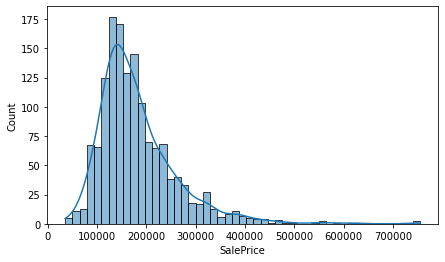

In [62]:
plt.figure(figsize=(7,4))
sns.histplot(data=data['SalePrice'], x =data['SalePrice'], kde=True)
plt.show()

In [63]:
data['SalePrice_log'] = np.log(data['SalePrice'])

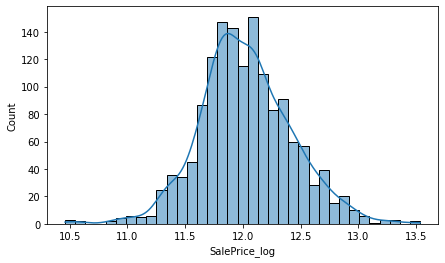

In [64]:
plt.figure(figsize=(7,4))
sns.histplot(data=data['SalePrice_log'], x =data['SalePrice_log'], kde=True)
plt.show()

## Step 5: Clean Your Data

In [65]:
#read the data set and make a copy
df = pd.read_csv("train.csv")
data = df.copy()

In [66]:
data['SalePrice_log'] = np.log(data['SalePrice'])

In [67]:
#drop the ID values
data = data.drop(['Id'], axis =1)

In [68]:
#MSSubClass while represented with an integer is really a category
data['MSSubClass'] = data['MSSubClass'].astype('object')

In [69]:
#Convert data object data type to category
cat_cols = data.select_dtypes(['object']).columns.tolist()
for col in cat_cols:
    data[col] = data[col].astype('category')

In [70]:
#Convert data int64 data type to float64
num_cols = data.select_dtypes(['int64']).columns.tolist()
for col in num_cols:
    data[col] = data[col].astype('float64')

In [71]:
#Fill category columns with mode
cat_cols = data.select_dtypes(['category']).columns.tolist()
for col in cat_cols:
    mode = data[col].mode()[0]
    data[col] = data[col].fillna(mode)

In [72]:
#Fill float64 columns with median
num_data = data.select_dtypes('number')
data[num_data.columns] = num_data.fillna(num_data.median())

We will generate a list of the dummy variables that we need to drop from the training data set because they are not available in the data set that will be used to generate final predictions.

In [73]:
#read the data set and make a copy
df = pd.read_csv("train.csv")
train = df.copy()

In [74]:
#read the data set and make a copy
df = pd.read_csv("test.csv")
pred = df.copy()

In [75]:
train = pd.get_dummies(train, drop_first = True)
pred  = pd.get_dummies(pred,  drop_first = True)

In [76]:
train = train.drop('SalePrice', axis = 1)
not_in_pred = list(set(train.columns.tolist())-set(pred.columns.tolist()))

## Step 6: Feature Engineering

Separating dependent from independent variables

In [77]:
# Create y (dependen variable)
y = data['SalePrice_log']

# Drop dependent variable from the dataframe and create the X(independen variable) matrix
X = data.drop(['SalePrice','SalePrice_log'], axis = 1)

# Create dummy variables for categorial variables
X = pd.get_dummies(X, drop_first=True)

# Drop dummy variables not available in the data set that will be used to generate final predictions
X = X.drop(not_in_pred, axis = 1)

# Add the intercept term
X = sm.add_constant(X)

## Step 7: Model Selection

We will be using a linear regression model.

## Step 8: Model Training and Evaluation

Splitting the data into 70% train and 30% test sets

In [78]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =1)

Check for Multicollinearity

We use the Variance Inflation Factor (VIF), to check if there is multicollinearity in the data.
Features with VIF score > 5 will be dropped/treated till all the features have a VIF score < 5

In [79]:
# function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]    
    return vif

In [80]:
# We will call the function using the training data set
VIF=checking_vif(X_train)

# We remove dummy variables and constants from the VIF dataframe
VIF=VIF.loc[~VIF['feature'].str.contains('_')].loc[~VIF['feature'].str.contains('const')]

# Now we drop variables that have a VIF higher than 5 but lower than INF
VIF=VIF.loc[VIF['VIF']>5.0].loc[VIF['VIF']<np.inf]

#Now we store the list of features with high VIF in a variable
to_drop=VIF['feature'].tolist()

In [81]:
#drop variables with high VIF
X_train = X_train.drop(columns = to_drop)

Now, we will create the linear regression model as the VIF is less than 5 for all the independent variables, and we can assume that multicollinearity has been removed between the variables.

In [82]:
# create the model
model1 = sm.OLS(y_train, X_train)
results1 = model1.fit()
results1_summary = results1.summary()

In [83]:
#We'll convert the results summary in a dataframe that we can later manipulate
results1_as_html = results1_summary.tables[1].as_html()
X_train_to_drop = pd.read_html(results1_as_html, header=0, index_col=0)[0]

#We Identify the variables that are not significant
X_train_to_drop =  X_train_to_drop.loc[X_train_to_drop['P>|t|'] > 0.05]

#We store the list of variables that are not significant in a variable
X_train_to_drop = X_train_to_drop.index.tolist()

#We try to remove the constant if it is has a P value higher than 0.05
try:
    X_train_to_drop.remove('const')
except:
    print('no const')

no const


In [84]:
# Create y (dependen variable)
y = data['SalePrice_log']

# Drop dependent variable from the dataframe and create the X(independen variable) matrix
X = data.drop(['SalePrice','SalePrice_log'], axis = 1)

#Drop variables with high VIF
X = X.drop(to_drop, axis = 1)

In [85]:
# Create dummy variables for categorial variables
X = pd.get_dummies(X, drop_first=True)

# Drop dummy variables not available in the data set that will be used to generate predictions
X = X.drop(not_in_pred, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop, axis = 1)

# Add the intercept term
X = sm.add_constant(X)

In [86]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =1)

In [87]:
# create the model
model2 = sm.OLS(y_train, X_train)
results2 = model2.fit()
results2_summary = results2.summary()

In [88]:
#print(results2_summary)

In [89]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results2_as_html = results2_summary.tables[1].as_html()
X_train_to_drop2 = pd.read_html(results2_as_html, header=0, index_col=0)[0]

#We Identify the variables that are not significant
X_train_to_drop2 =  X_train_to_drop2.loc[X_train_to_drop2['P>|t|'] > 0.05]

#We store the list of variables that are not significant in a variable
X_train_to_drop2 = X_train_to_drop2.index.tolist()

#We try to remove the constant if it is has a P value higher than 0.05
try:
    X_train_to_drop2.remove('const')
except:
    print('no const')

no const


In [90]:
# Create y (dependen variable)
y = data['SalePrice_log']

# Drop dependent variable from the dataframe and create the X(independen variable) matrix
X = data.drop(['SalePrice','SalePrice_log'], axis = 1)

#Drop variables with high VIF
X = X.drop(to_drop, axis = 1)

In [91]:
# Create dummy variables for categorial variables
X = pd.get_dummies(X, drop_first=True)

# Drop dummy variables not available in the data set that will be used to generate predictions
X = X.drop(not_in_pred, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop2, axis = 1)

# Add the intercept term
X = sm.add_constant(X)

In [92]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =1)

In [93]:
# create the model
model3 = sm.OLS(y_train, X_train)
results3 = model3.fit()
results3_summary = results3.summary()

In [94]:
#You can print the summary to visually identify variables with P>0.05
#print(results3_summary)

In [95]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results3_as_html = results3_summary.tables[1].as_html()
X_train_to_drop3 = pd.read_html(results3_as_html, header=0, index_col=0)[0]

#We Identify the variables that are not significant
X_train_to_drop3 =  X_train_to_drop3.loc[X_train_to_drop3['P>|t|'] > 0.05]

#We store the list of variables that are not significant in a variable
X_train_to_drop3 = X_train_to_drop3.index.tolist()

#We try to remove the constant if it is has a P value higher than 0.05
try:
    X_train_to_drop3.remove('const')
except:
    print('no const')

no const


In [96]:
# Create y (dependen variable)
y = data['SalePrice_log']

# Drop dependent variable from the dataframe and create the X(independen variable) matrix
X = data.drop(['SalePrice','SalePrice_log'], axis = 1)

#Drop variables with high VIF
X = X.drop(to_drop, axis = 1)

In [97]:
# Create dummy variables for categorial variables
X = pd.get_dummies(X, drop_first=True)

# Drop dummy variables not available in the data set that will be used to generate predictions
X = X.drop(not_in_pred, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop2, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop3, axis = 1)

# Add the intercept term
X = sm.add_constant(X)

In [98]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =1)

In [99]:
# create the model
model4 = sm.OLS(y_train, X_train)
results4 = model4.fit()
results4_summary = results4.summary()

In [100]:
#You can print the summary to visually identify variables with P>0.05
#print(results4_summary)

In [101]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results4_as_html = results4_summary.tables[1].as_html()
X_train_to_drop4 = pd.read_html(results4_as_html, header=0, index_col=0)[0]

#We Identify the variables that are not significant
X_train_to_drop4 =  X_train_to_drop4.loc[X_train_to_drop4['P>|t|'] > 0.05]

#We store the list of variables that are not significant in a variable
X_train_to_drop4 = X_train_to_drop4.index.tolist()

#We try to remove the constant if it is has a P value higher than 0.05
try:
    X_train_to_drop4.remove('const')
except:
    print('no const')

no const


In [102]:
# Create y (dependen variable)
y = data['SalePrice_log']

# Drop dependent variable from the dataframe and create the X(independen variable) matrix
X = data.drop(['SalePrice','SalePrice_log'], axis = 1)

#Drop variables with high VIF
X = X.drop(to_drop, axis = 1)

In [103]:
# Create dummy variables for categorial variables
X = pd.get_dummies(X, drop_first=True)

# Drop dummy variables not available in the data set that will be used to generate predictions
X = X.drop(not_in_pred, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop2, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop3, axis = 1)

#Drop variables that are not significant
X = X.drop(X_train_to_drop4, axis = 1)

# Add the intercept term
X = sm.add_constant(X)

In [104]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =1)

In [105]:
# create the model
model5 = sm.OLS(y_train, X_train)
results5 = model5.fit()
results5_summary = results5.summary()

In [106]:
#print(results5_summary)

In [107]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test):

    # In-sample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    )


In [108]:
# Checking model performance
model_pref(results5, X_train, X_test)  

    Data      RMSE       MAE      MAPE
0  Train  0.134952  0.098047  0.815780
1   Test  0.170843  0.121021  1.019781


In [109]:
# import the required function

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


# build the regression model and cross-validate
linearregression = LinearRegression()                                    

cv_Score11 = cross_val_score(linearregression, X_train, y_train, cv = 10)
cv_Score12 = cross_val_score(linearregression, X_train, y_train, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))
print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.807 (+/- 0.270)
Mean Squared Error: 0.027 (+/- 0.034)


## Step 9: Prediction Generation

In [110]:
#read the data set and make a copy
df = pd.read_csv("test.csv")
predictiondata = df.copy()

#drop the ID values
predictiondata = predictiondata.drop(['Id'], axis =1)

#MSSubClass while represented with an integer is really a category
predictiondata['MSSubClass'] = predictiondata['MSSubClass'].astype('object')

#Convert data object data type to category
cat_cols = predictiondata.select_dtypes(['object']).columns.tolist()
for col in cat_cols:
    predictiondata[col] = predictiondata[col].astype('category')

#Convert data int64 data type to float64
num_cols = predictiondata.select_dtypes(['int64']).columns.tolist()
for col in num_cols:
    predictiondata[col] = predictiondata[col].astype('float64')

#Fill category columns with mode
cat_cols = predictiondata.select_dtypes(['category']).columns.tolist()
for col in cat_cols:
    mode = predictiondata[col].mode()[0]
    predictiondata[col] = predictiondata[col].fillna(mode)
    
#Fill float64 columns with median
num_data = predictiondata.select_dtypes('number')
predictiondata[num_data.columns] = num_data.fillna(num_data.median())

In [111]:
# Create dummy variables for categorial variables
predictiondata= pd.get_dummies(predictiondata, drop_first=True)

In [112]:
# Add the intercept term
predictiondata = sm.add_constant(predictiondata)

In [113]:
#Drop variables that are not significant
predictiondata = predictiondata.drop(X_train_to_drop, axis = 1)

#Drop variables that are not significant
predictiondata = predictiondata.drop(X_train_to_drop2, axis = 1)

#Drop variables that are not significant
predictiondata = predictiondata.drop(X_train_to_drop3, axis = 1)

#Drop variables that are not significant
predictiondata = predictiondata.drop(X_train_to_drop4, axis = 1)

In [114]:
predictiondata = predictiondata[X_train.columns.tolist()]

In [115]:
validation_predictions = results5.predict(predictiondata)

## Step 10: Prediction Submission

In [116]:
#We transform prices back to dollars
output=np.exp(validation_predictions)

In [117]:
#We read the submission file and replace the SalesPrice column data
submission = pd.read_csv("sample_submission.csv")
submission['SalePrice'] = output

In [118]:
#We store the data in a csv file
submission.to_csv("nth_submission.csv", index=False) 